In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

## Load data sources

In [3]:
# load the list which assigns events to categories
filename_event_list = "../moodle_default_events_list.xlsx"
event_list = pd.read_excel(filename_event_list, header=7)
event_list = event_list.rename(columns = {"Extracted Event Name":"eventname", "Active/Passive":"activepassive", "User-Agent-Based":"useragentbased", "Novel Learning-Cycle":"newlc"})
event_list = event_list[["eventname", "activepassive", "useragentbased", "newlc"]]
event_list[:3]

,eventname,activepassive,useragentbased,newlc
0,\core\event\badge_archived,22 passive,4 Student-System,NaN
1,\core\event\badge_awarded,22 passive,6 Course Relevant Actions,NaN
2,\core\event\badge_created,NaN,5 Others,NaN


In [4]:
# convert columns to strings for the events
event_list_string_columns = ["eventname", "activepassive", "useragentbased", "newlc"]
for c in event_list_string_columns:
  event_list[c] = event_list[c].astype('string')

In [101]:
# load the moodle course log
filename_course_log = 'course_log.pkl'
course_log_list = pd.read_pickle(filename_course_log)
course_log = pd.DataFrame(course_log_list)
course_log[:3]

,action,target,crud,contextlevel,edulevel,eventname,userid,role,relateduserid,courseid,timecreated
0,viewed,course,r,50,2,\core\event\course_viewed,13,norole,NaN,3,1598956500
1,viewed,user_list,r,50,0,\core\event\user_list_viewed,13,norole,NaN,3,1598956507
2,viewed,user_list,r,50,0,\core\event\user_list_viewed,13,norole,NaN,3,1598956516
3,viewed,user_list,r,50,0,\core\event\user_list_viewed,13,norole,NaN,3,1598956520
4,viewed,course,r,50,2,\core\event\course_viewed,13,norole,NaN,3,1598956523
...,...,...,...,...,...,...,...,...,...,...,...
11808,viewed,course,r,50,2,\core\event\course_viewed,2,norole,NaN,3,1640560254
11809,viewed,course_module,r,70,2,\mod_workshop\event\course_module_viewed,2,norole,NaN,3,1640560258
11810,viewed,course_module,r,70,2,\mod_workshop\event\course_module_viewed,2,norole,NaN,3,1640560284
11811,viewed,course_module,r,70,2,\mod_workshop\event\course_module_viewed,2,norole,NaN,3,1640560316


In [6]:
# convert columns to strings for the course log
# TODO: 'role' has been renamed to 'userrole' in new data export from moodle plugin
course_log_string_columns = ["action", "target", "crud", "eventname", "role"]
for c in course_log_string_columns:
  course_log[c] = course_log[c].astype('string')

## Start data handling

In [7]:
# count the occurrence of each event type
event_frequency = course_log.groupby(["userid","eventname"]).count()
event_frequency = event_frequency.drop(labels=[c for c in event_frequency.columns[1:]], axis="columns")
event_frequency = event_frequency.rename(columns = {"action":"count"})
event_frequency = event_frequency.reset_index()
event_frequency

,userid,eventname,count
0,2,\core\event\capability_assigned,1
1,2,\core\event\course_restored,1
2,2,\core\event\course_section_created,3
3,2,\core\event\course_viewed,8
4,2,\core\event\enrol_instance_created,1
...,...,...,...
803,76,\mod_workshop\event\course_module_viewed,19
804,76,\mod_workshop\event\submission_assessed,7
805,76,\mod_workshop\event\submission_created,2
806,76,\mod_workshop\event\submission_updated,2


In [8]:
# somehow the type gets lost when grouping on it
event_frequency["eventname"] = event_frequency["eventname"].astype('string')

In [10]:
# map events with interaction categories
overview = pd.merge(event_frequency, event_list, how="left", on="eventname")
overview

,userid,eventname,count,activepassive,useragentbased,newlc
0,2,\core\event\capability_assigned,1,<NA>,5 Others,<NA>
1,2,\core\event\course_restored,1,<NA>,5 Others,<NA>
2,2,\core\event\course_section_created,3,<NA>,5 Others,<NA>
3,2,\core\event\course_viewed,8,22 passive,3 Student-Content,1 Engagement
4,2,\core\event\enrol_instance_created,1,<NA>,5 Others,<NA>
...,...,...,...,...,...,...
803,76,\mod_workshop\event\course_module_viewed,19,11 active,3 Student-Content,2 Content
804,76,\mod_workshop\event\submission_assessed,7,11 active,3 Student-Content,3 Application
805,76,\mod_workshop\event\submission_created,2,11 active,3 Student-Content,3 Application
806,76,\mod_workshop\event\submission_updated,2,11 active,3 Student-Content,3 Application


In [11]:
# only get rows with at least one
nan_mask = overview["newlc"].notnull()
overview_newlc = overview[nan_mask]
overview_newlc

,userid,eventname,count,activepassive,useragentbased,newlc
3,2,\core\event\course_viewed,8,22 passive,3 Student-Content,1 Engagement
11,2,\core\event\user_list_viewed,3,<NA>,5 Others,6 LPM
12,2,\mod_assign\event\course_module_viewed,2,22 passive,3 Student-Content,2 Content
13,2,\mod_assign\event\submission_status_viewed,2,22 passive,3 Student-Content,5 Track/review
14,2,\mod_resource\event\course_module_viewed,1,11 active,3 Student-Content,2 Content
...,...,...,...,...,...,...
803,76,\mod_workshop\event\course_module_viewed,19,11 active,3 Student-Content,2 Content
804,76,\mod_workshop\event\submission_assessed,7,11 active,3 Student-Content,3 Application
805,76,\mod_workshop\event\submission_created,2,11 active,3 Student-Content,3 Application
806,76,\mod_workshop\event\submission_updated,2,11 active,3 Student-Content,3 Application


In [12]:
newlc_per_student = overview_newlc.groupby(["userid","newlc"]).sum()
newlc_per_student

count
userid newlc                
2      1 Engagement        8
       2 Content           6
       5 Track/review      2
       6 LPM               3
4      1 Engagement        5
...                      ...
74     5 Track/review     57
76     1 Engagement       54
       2 Content          75
       3 Application      19
       5 Track/review     25

[162 rows x 1 columns]

In [34]:
# get all different categories from the original event list
newlc_categories = event_list[~event_list["newlc"].isna()]["newlc"].unique()
newlc_categories = sorted(newlc_categories)
newlc_categories

['1 Engagement',
 '2 Content',
 '3 Application',
 '4 Dialogue/sharing',
 '5 Track/review',
 '6 LPM']

In [39]:
newlc_per_student = overview_newlc.groupby(["userid","newlc"]).sum()
# insert 0 values for absent indices
newlc_per_student = newlc_per_student.reindex( pd.MultiIndex.from_product([newlc_per_student.index.levels[0], 
newlc_categories], names=['userid', 'newlc']),fill_value=0)
newlc_per_student

count
userid newlc                    
2      1 Engagement            8
       2 Content               6
       3 Application           0
       4 Dialogue/sharing      0
       5 Track/review          2
...                          ...
76     2 Content              75
       3 Application          19
       4 Dialogue/sharing      0
       5 Track/review         25
       6 LPM                   0

[228 rows x 1 columns]

### Radar Chart Meta Functions
From: https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

In [13]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [14]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

### Create Basic Radar Chart

In [15]:
data_labels = ["Engagement", "Content", "Application", "Dialogue/sharing", "Track/review", "LPM"]
data = [
  [1,2,3,4,5,6],
  [6,5,4,3,2,1]
]
N = len(data[0])
theta = radar_factory(N, frame='polygon')
colors = ['b', 'r']

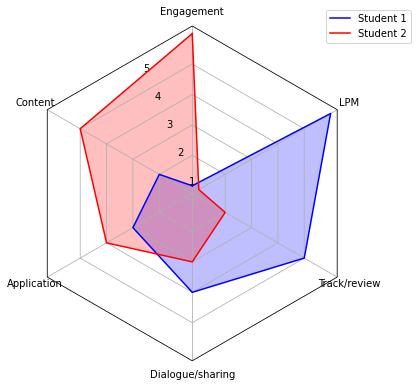

In [16]:
fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05) # required to position labels properly

# define the radial gridlines (TODO: caluculate automatically from input data, min-max proper spacing)
ax.set_rgrids([0, 1, 2, 3, 4, 5])

# plot the data
for d, color in zip(data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
ax.set_varlabels(data_labels)

# add legend
labels = ('Student 1', 'Student 2')
legend = ax.legend(labels, loc=(0.9, .95))

plt.show()


### Create Generic Comparative Radar Chart

In [17]:
newlc_per_student

count
userid newlc                
2      1 Engagement        8
       2 Content           6
       5 Track/review      2
       6 LPM               3
4      1 Engagement        5
...                      ...
74     5 Track/review     57
76     1 Engagement       54
       2 Content          75
       3 Application      19
       5 Track/review     25

[162 rows x 1 columns]

In [19]:
""" Return the sum of events of all newlc categories for a student. 
"""
def get_events_per_category_for_student(userid):
  selected_student = newlc_per_student.query(f'userid == {userid}')
  # remove and drop userid index as only one student selected
  selected_student = selected_student.reset_index(level=0)
  selected_student = selected_student.drop('userid', axis=1)
  # insert 0 values for absent indices
  selected_student = selected_student.reindex(newlc_categories, fill_value=0)
  return selected_student["count"].values


In [20]:
def plot_radar_chart(data, data_labels):
  N = len(data[0])
  theta = radar_factory(N, frame='polygon')
  colors = ['b', 'r', 'g', 'm', 'y']

  # start preparing the plot
  fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
  fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05) # required to position labels properly

  # define the radial gridlines (TODO: caluculate automatically from input data, min-max proper spacing)
  # ax.set_rgrids([0, 1, 2, 3, 4, 5])

  # plot the data
  for d, color in zip(data, colors[:len(data)]):
      ax.plot(theta, d, color=color)
      ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
  ax.set_varlabels(newlc_categories)

  # add legend
  ax.legend(data_labels, loc=(0.9, .95))

  plt.show()


In [21]:
def compare_students(userid_a, userid_b):
  data = [
    get_events_per_category_for_student(userid_a),
    get_events_per_category_for_student(userid_b)
  ]
  data_labels = (f'Student {userid_a}', f'Student {userid_b}')
  plot_radar_chart(data, data_labels)


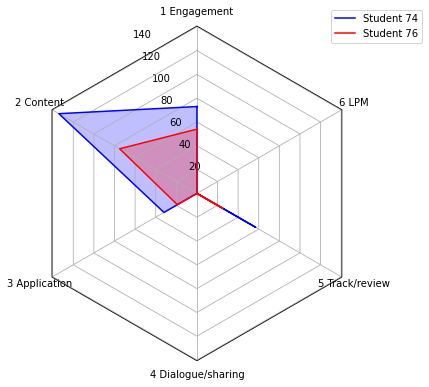

In [22]:
compare_students(74, 76)

### Create Radar Chart Compared to Average

In [23]:
newlc_sum = overview_newlc.groupby("newlc").sum()["count"]
newlc_sum

newlc
1 Engagement          2896
2 Content             3615
3 Application          842
4 Dialogue/sharing      24
5 Track/review        1585
6 LPM                  347
Name: count, dtype: int64

In [31]:
newlc_sum = overview_newlc[:3].groupby("newlc").sum()["count"]

# insert 0 values for absent indexes
newlc_sum = newlc_sum.reindex(newlc_categories, fill_value=0)
newlc_sum

newlc
1 Engagement          8
2 Content             2
3 Application         0
4 Dialogue/sharing    0
5 Track/review        0
6 LPM                 3
Name: count, dtype: int64

In [28]:
newlc_sum = overview_newlc[:3].groupby("newlc").sum()["count"]
# insert 0 values for absent indexes
newlc_sum = newlc_sum.reindex(newlc_categories, fill_value=0)

nbr_users = len(overview_newlc["userid"].unique())
average = newlc_sum.divide(nbr_users).values
average

array([0.21052632, 0.05263158, 0.07894737])

In [252]:
nbr_users = len(overview_newlc["userid"].unique())
nbr_users

38

In [257]:
def compare_student_to_average(userid):
  # compute average data
  newlc_sum = overview_newlc.groupby("newlc").sum()["count"]
  nbr_users = len(overview_newlc["userid"].unique())
  average = newlc_sum.divide(nbr_users).values

  # plot comparision
  data = [
    get_events_per_category_for_student(userid),
    average
  ]
  data_labels = (f'Student {userid}', f'Average')
  plot_radar_chart(data, data_labels)

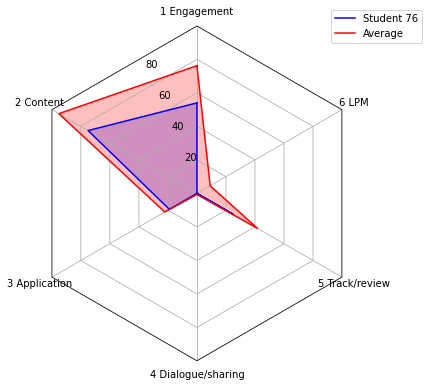

In [258]:
compare_student_to_average(76)

### Box Plot

In [260]:
newlc_per_student

count
userid newlc                
2      1 Engagement        8
       2 Content           6
       5 Track/review      2
       6 LPM               3
4      1 Engagement        5
...                      ...
74     5 Track/review     57
76     1 Engagement       54
       2 Content          75
       3 Application      19
       5 Track/review     25

[162 rows x 1 columns]

In [268]:
''' Return the count for a category of each user in an array.
'''
def get_newlc_category_count_per_user(newlc_category):
  return newlc_per_student.query("newlc == @newlc_category")["count"].values

In [270]:
data = [get_newlc_category_count_per_user(category) for category in newlc_categories]
data

[array([  8,   5, 291,  58,   2,  83, 115,   4, 102,  68,  82,  62,  83,
         56, 105,  87,  60, 145, 120,  53,  41,  30,  61,  58,  49,  99,
        101,  55,  81,  88, 194,  79, 123,  52,  69,  73,  54]),
 array([  6,   5, 256,  96,  86, 108,   3, 116,  62, 114,  74, 103,  92,
        119, 117,  71, 108, 105,  73,  74,  51,  84, 117,  63, 103, 124,
         91, 130, 118, 318,  85, 134, 121,  79, 134,  75]),
 array([74, 22, 23, 24, 14, 18, 19, 21, 19, 24, 22, 23, 16, 30, 22, 22, 19,
        24, 30, 22, 25, 21, 14, 38, 27, 77, 29, 25, 24, 23, 32, 19]),
 array([24]),
 array([  2,   5, 110,  67,  48,  48,  56,  38,  32,  29,  51,  31,  32,
         37,  32,  69,  66,  17,  25,  23,  32,  53,  36,  57,  59,  33,
         57,  40, 109,  43,  84,  41,  41,  57,  25]),
 array([  3,   1, 165,  92,  51,   3,   3,   2,   3,   6,   3,   1,   2,
          1,   1,   2,   2,   3,   1,   1,   1])]

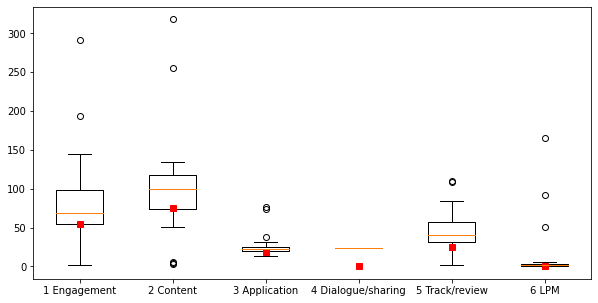

In [296]:
fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot(data, labels=newlc_categories)
# add points of the student of interest
student_data = get_events_per_category_for_student(76)
ax_indices = [x+1 for x in range(len(student_data))] # because they start at index 1
ax.plot(ax_indices, student_data, 'rs')
plt.show()

# OPEN TODOS

In [ ]:
# TODO: include the final grade in the data output

In [ ]:
# TODO: filter the initial dataframe for teachers. As well remove admin (userid 2). --> could be done with hierarchical filters (norole/teacher)

In [ ]:
# TODO: on webapp, show raw results in table for better comparision

### Basic Analysis for old Categorization

<BarContainer object of 5 artists>

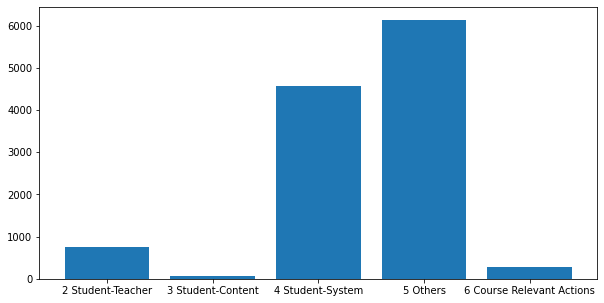

In [86]:
# TODO: delete since obsolete, keep just as reference for the moment 22.02.2022
# repeat counting (for compatibility)
event_frequency = course_log.groupby(["eventname"]).count()
overview = event_frequency.join(event_list, rsuffix="_ef").drop("eventname_ef", axis='columns')

user_agent_based = overview.groupby("useragentbased").sum()["count"]
plt.figure(figsize=(10,5))
plt.bar(user_agent_based.index, user_agent_based)

<BarContainer object of 2 artists>

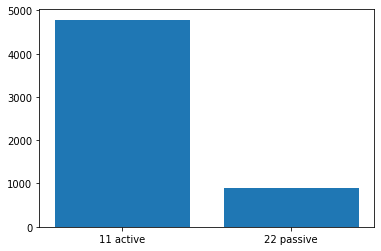

In [88]:
active_passive = overview.groupby("activepassive").sum()["count"]
plt.bar(active_passive.index, active_passive)